# Make finger-tapping ROIs for experiment 3 power analysis
Use Neurosynth meta-analysis and AAL atlas to create left and right finger-tapping ROIs in MNI space for power analysis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting
import nibabel as nib
import numpy as np
from scipy import ndimage
import seaborn as sns

In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def get_cluster(mat, thresh=0.):
    """
    Return the binarized maximum cluster mask for a statistical map matrix.
    """
    conn_mat = np.ones((3, 3, 3), int)  # 6-connectivity, aka NN1 or "faces"
    binarized = mat > thresh
    binarized = binarized.astype(int)
    
    # If the stat threshold is too high simply return an empty dataframe
    if np.sum(binarized) == 0:
        raise Exception('Attention: No clusters.')

    # Extract connected components above cluster size threshold
    label_map = ndimage.measurements.label(binarized, conn_mat)[0]
    clust_ids = sorted(list(np.unique(label_map)[1:]))
    clust_sizes = [np.sum(label_map==cid) for cid in clust_ids]
    max_clust_idx = clust_sizes.index(max(clust_sizes))
    max_clust_id = clust_ids[max_clust_idx]
    clust_map = label_map == max_clust_id
    return clust_map.astype(int)

## First, we will use hand-traced regions of interest to estimate the typical hand knob size in mm3
The hand-traced regions of interest have been provided by Dr. Dan Handwerker from [Handwerker et al. (2020)](https://doi.org/10.1162/netn_a_00145).

In [3]:
lh_file = '/Users/tsalo/Downloads/Hand Motor Knob ROIs/SeedMasks.AllSbj.lhK_HandDrawn+tlrc.BRIK.gz'
rh_file = '/Users/tsalo/Downloads/Hand Motor Knob ROIs/SeedMasks.AllSbj.rhK_HandDrawnSeed+tlrc.BRIK.gz'
lh_img = nib.load(lh_file)
rh_img = nib.load(rh_file)
print('There are {} participants.'.format(lh_img.shape[-1]))

There are 16 participants.


In [4]:
# Now to collect the sizes
voxel_size = np.prod(lh_img.header.get_zooms()[:3])
print(voxel_size)
lh_voxel_counts = np.sum(np.sum(np.sum(lh_img.get_fdata(), axis=0), axis=0), axis=0)
lh_mm3 = lh_voxel_counts * voxel_size

rh_voxel_counts = np.sum(np.sum(np.sum(rh_img.get_fdata(), axis=0), axis=0), axis=0)
rh_mm3 = rh_voxel_counts * voxel_size

1.0


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


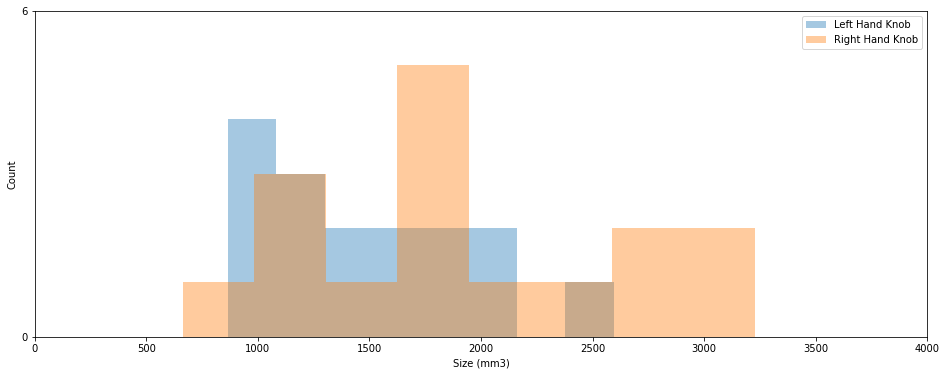

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(lh_mm3, label='Left Hand Knob', ax=ax,
             bins=8, norm_hist=False, kde=False)
sns.distplot(rh_mm3, label='Right Hand Knob', ax=ax,
             bins=8, norm_hist=False, kde=False)
ax.set_xlabel('Size (mm3)')
ax.set_ylabel('Count')
ax.set_yticks([0, 6])
ax.set_xlim((0, 4000))
ax.legend()
fig.show()

In [6]:
mean_roi_size = np.mean(np.hstack((lh_mm3, rh_mm3)))
print('Average hand knob size: {0:.02f} mm3'.format(mean_roi_size))
target_voxel_size = 8  # 2 x 2 x 2 mm
target_roi_size = int(np.ceil(mean_roi_size / target_voxel_size))
print('Target ROI size: {} voxels'.format(target_roi_size))

Average hand knob size: 1718.56 mm3
Target ROI size: 215 voxels


## Now we can build our power analysis ROIs
We grab structural masks corresponding to bilateral precentral gyri from the AAL and meta-analytic statistical maps for the "finger" label from Neurosynth. Then, we make the Neurosynth map with each structural ROI, and gradually increase our thresholds until there is roughly the target number of voxels in each hemisphere's ROI.

In [7]:
aal = fetch_atlas_aal()
aal_img = nib.load(aal['maps'])
aal_map = aal_img.get_data()
l_precentral_idx = int(aal['indices'][aal['labels'].index('Precentral_L')])
r_precentral_idx = int(aal['indices'][aal['labels'].index('Precentral_R')])
l_precentral = aal_map == l_precentral_idx
r_precentral = aal_map == r_precentral_idx

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


In [8]:
finger_meta = 'data/finger_association-test_z_FDR_0.01.nii.gz'
finger_img = nib.load(finger_meta)
finger_map = finger_img.get_fdata()

# Use conjunction of hemisphere-specific precentral gyrus masks
# and thresholded finger tapping map. Only keep largest cluster,
# when more than one survives
l_finger_clust = np.ones(finger_img.shape)
thresh = 9.
while np.sum(l_finger_clust) > target_roi_size:
    thresh_finger_map = finger_map >= thresh
    l_finger = (l_precentral * thresh_finger_map).astype(int)
    l_finger_clust = get_cluster(l_finger)
    thresh += 0.01
print('Left finger image thresholded at {0:.02f} for {1} '
      'voxels'.format(thresh, np.sum(l_finger_clust)))
l_finger_img = nib.Nifti1Image(l_finger_clust, finger_img.affine)

r_finger_clust = np.ones(finger_img.shape)
thresh = 7.
while np.sum(r_finger_clust) > target_roi_size:
    thresh_finger_map = finger_map >= thresh
    r_finger = (r_precentral * thresh_finger_map).astype(int)
    r_finger_clust = get_cluster(r_finger)
    thresh += 0.01
print('Right finger image thresholded at {0:.02f} for {1} '
      'voxels'.format(thresh, np.sum(r_finger_clust)))
r_finger_img = nib.Nifti1Image(r_finger_clust, finger_img.affine)

b_finger_img = nib.Nifti1Image(
    l_finger_img.get_fdata()+r_finger_img.get_fdata(),
    finger_img.affine)

Left finger image thresholded at 12.59 for 215 voxels
Right finger image thresholded at 10.18 for 215 voxels


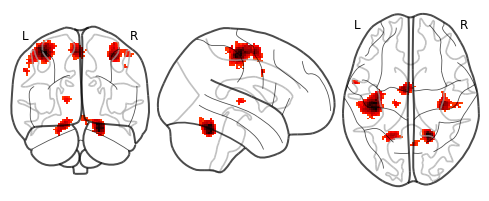

In [9]:
plotting.plot_glass_brain(finger_img, threshold=thresh)

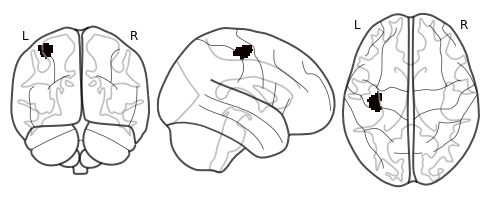

In [10]:
plotting.plot_glass_brain(l_finger_img)
l_finger_img.to_filename('data/left_finger_ROI.nii.gz')

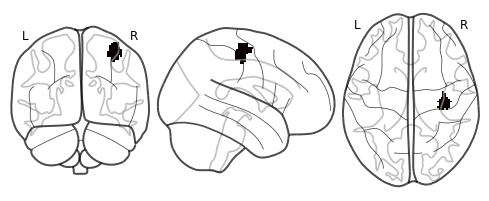

In [11]:
plotting.plot_glass_brain(r_finger_img)
r_finger_img.to_filename('data/right_finger_ROI.nii.gz')

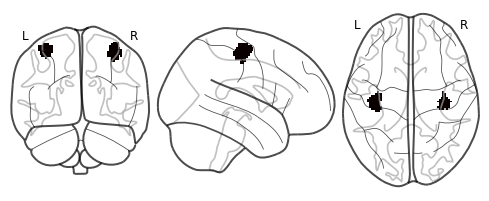

In [12]:
# Just to see them together
plotting.plot_glass_brain(b_finger_img)

In [13]:
# and save a figure for the manuscript
plotting.plot_glass_brain(b_finger_img, output_file='data/finger_rois.png')